In [2]:
import os
import requests
import json
from datetime import datetime, timedelta

# API를 요청할 URL과 인증키
BASE_URL = "https://www.koreaexim.go.kr/site/program/financial/exchangeJSON"
AUTH_KEY = os.getenv('KOREAEXSIM_OPEN_API_KEY')  # 여기에 본인의 인증키를 넣어주세요
print(f"AUTH_KEY={AUTH_KEY}")

# 오늘 날짜부터 지정한 day 수만큼 날짜를 생성하는 함수
def generate_dates(start_date, total_days):
    dates = []
    end_date = start_date - timedelta(days=total_days)
    while start_date > end_date:
        dates.append(start_date.strftime("%Y%m%d"))
        start_date -= timedelta(days=1)
    return dates

# 주어진 날짜에 대해 USD 환율 정보를 요청하는 함수
def fetch_usd_data_for_date(date):
    params = {
        "authkey": AUTH_KEY,
        "searchdate": date,
        "data": "AP01"
    }
    response = requests.get(BASE_URL, params=params)
    
    if response.status_code == 200:
        data = response.json()
        return data
    else:
        return None

# USD 데이터를 날짜별로 저장하는 함수
def get_usd_bkpr_over_days(start_date, total_days):
    dates = generate_dates(start_date, total_days)
    usd_data = {}

    for date in dates:
        data = fetch_usd_data_for_date(date)
        
        # 빈 배열인지 확인 (휴일인 경우)
        if data and isinstance(data, list) and len(data) > 0:
            # USD 데이터를 찾기
            for entry in data:
                if entry.get("cur_unit") == "USD":
                    usd_data[date] = entry.get("bkpr")
                    usd_data[date] = usd_data[date].replace(',', '') # 통화에서 쉽표 제거하기
                    break  # USD 데이터를 찾으면 더 이상 탐색하지 않음
        else:
            # 휴일인 경우
            print(f"Data unavailable for {date} (possibly a holiday)")

    return usd_data

AUTH_KEY=1p25bUnirmJUSZgqS9iWm4HrFM2ODhra


In [3]:
# 시작 날짜를 설정 (2024년 10월 4일)
start_date = datetime(2024, 10, 15)

# 365 * 3일치 USD bkpr 데이터를 가져오기
total_days = 10
usd_bkpr_data = get_usd_bkpr_over_days(start_date, total_days)

# # 결과 출력
print("USD bkpr values over the specified number of days:")
for date, bkpr in usd_bkpr_data.items():
    print(f"{date}: {bkpr}")

ConnectionError: ('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))

In [2]:
import sqlite3
import os

# sqlite3db 디렉토리가 없으면 생성
if not os.path.exists('sqlite3db'):
    os.makedirs('sqlite3db')

# sqlite3db 디렉토리 아래에 데이터베이스 파일 경로 설정
db_path = os.path.join('sqlite3db', 'exchange_rates.db')

# 데이터베이스 파일에 연결 (파일이 없으면 새로 생성됨)
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# 테이블 생성 (존재하지 않으면 생성)
# date를 PRIMARY KEY로 설정
cursor.execute('''
    CREATE TABLE IF NOT EXISTS exchange_rates (
        date TEXT PRIMARY KEY,
        currency TEXT,
        bkpr REAL
    )
''')

In [3]:
# 데이터를 테이블에 삽입하거나 중복 발생 시 업데이트하는 함수
def insert_or_update_exchange_rate_data(data):
    count = 0  # 삽입한 데이터 개수 카운터
    for date, bkpr in data.items():
        try:
            cursor.execute('''
                INSERT INTO exchange_rates (date, currency, bkpr)
                VALUES (?, ?, ?)
            ''', (date, 'USD', bkpr))

            count += 1  # 데이터 삽입 카운터 증가
        except sqlite3.IntegrityError:
            # 중복된 date 값을 삽입하려 하면 무시
            print(f"Data for {date} already exists, skipping.")

        # 30개마다 commit
        if count % 30 == 0:
            conn.commit()  # 변경사항 저장
            print(f"Committed {count} records.")

    # 남아있는 데이터가 30개 미만일 경우 마지막으로 commit
    conn.commit()
    print(f"Committed {count} records in total.")

In [15]:
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# 시작 날짜를 설정 (2024년 10월 4일)
start_date = datetime(2024, 10, 15)

# get_usd_bkpr_over_days 함수로 365 * 3일에 해당하는 환율 정보 가져오기
usd_bkpr_data = get_usd_bkpr_over_days(start_date, 30)

# 테이블에 데이터 삽입 또는 업데이트
insert_or_update_exchange_rate_data(usd_bkpr_data)

# 변경사항 저장
conn.commit()

# datetime 객체를 SQL 쿼리에 사용할 수 있도록 문자열로 변환
start_date_str = start_date.strftime('%Y-%m-%d')

# 데이터 확인을 위해 조회
cursor.execute('SELECT * FROM exchange_rates WHERE date <= ?', (start_date_str,))
rows = cursor.fetchall()

# 결과 출력
for row in rows:
    print(row)

# 연결 종료
conn.close()

Committed 0 records in total.


In [16]:
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# 데이터 확인을 위해 조회
cursor.execute('SELECT COUNT(1) FROM exchange_rates')
count = cursor.fetchone()

# 결과 출력
print(count)

cursor.close()

(614,)


In [21]:
# 오늘 환율 정보 조회하기
from datetime import date

# API에서 오늘의 USD 통화 가격을 가져와 DB에 저장하는 함수
def fetch_and_store_exchange_rate():
    # 오늘의 날짜 가져오기
    today = date.today()
    
    # fetch_usd_data_for_date를 사용하여 오늘의 통화 데이터를 가져옴
    usd_bkpr = fetch_usd_data_for_date(today)
    
    if usd_bkpr:
        # 통화 가격에 쉼표가 있을 경우 제거
        usd_bkpr = float(usd_bkpr.replace(',', ''))
        # DB에 저장
        store_exchange_rate(today, 'USD', usd_bkpr)
        print(f"Stored today's USD exchange rate: {usd_bkpr}")
    else:
        print("No USD data available for today.")


In [22]:
#  3년 동안의 데이터를 가져온 후 평균값을 계산하고, 오늘의 가격과 비교하기

from datetime import timedelta

# 3년 평균 가격과 오늘의 가격을 계산하고 출력하는 함수
def calculate_and_print_average():
    # 오늘의 날짜와 3년 전 날짜 계산
    today = date.today()
    three_years_ago = today - timedelta(days=365 * 3)
    
    # get_usd_bkpr_over_days를 사용해 3년치 데이터를 가져옴
    usd_bkpr_data = get_usd_bkpr_over_days((today - three_years_ago).days)
    
    # pandas DataFrame으로 변환 (편리한 데이터 처리)
    df = pd.DataFrame(usd_bkpr_data.items(), columns=['date', 'bkpr'])
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    
    # 3년 평균 가격 계산
    three_year_average = df['bkpr'].mean()
    
    # 오늘의 가격 가져오기
    today_bkpr = df.loc[str(today), 'bkpr']
    
    # 결과 출력
    print(f"Today's USD BKPR: {today_bkpr}")
    print(f"3-Year Average USD BKPR: {three_year_average:.2f}")


In [ ]:
# 매일 오후 6시에 스케쥴링하여 오늘의 환율 조회하기
import schedule
import time

# 매일 오후 6시에 작업 실행
schedule.every().day.at("18:00").do(lambda: [fetch_and_store_exchange_rate(), calculate_and_print_average()])

# 스케줄 실행 대기 루프
while True:
    schedule.run_pending()  # 예정된 작업을 실행
    time.sleep(60)  # 60초마다 작업 확인

3-Year Average BKPR: 1324.50


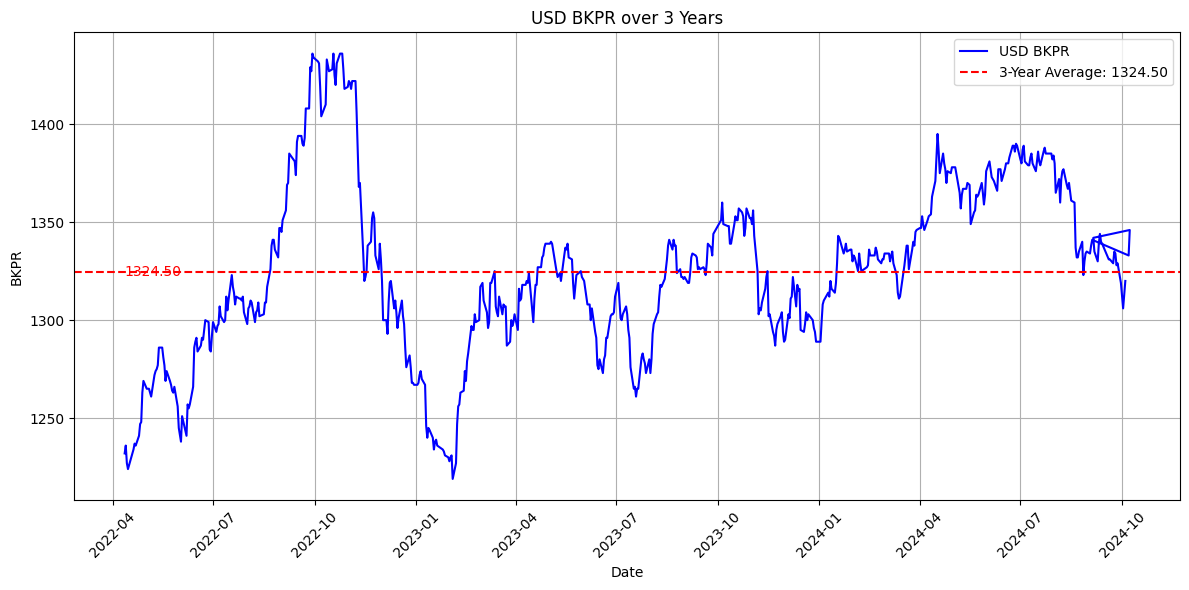

In [20]:
# 그래프로 나타내기

import sqlite3
import os
import pandas as pd
import matplotlib.pyplot as plt

# sqlite3db 디렉토리 아래에 데이터베이스 파일 경로 설정
db_path = os.path.join('sqlite3db', 'exchange_rates.db')

# 데이터베이스 파일에 연결
conn = sqlite3.connect(db_path)

# 데이터베이스에서 데이터 조회
query = 'SELECT date, bkpr FROM exchange_rates WHERE currency = "USD"'
df = pd.read_sql_query(query, conn)

# 연결 종료
conn.close()

# 데이터 처리
df['date'] = pd.to_datetime(df['date'])  # 날짜 형식으로 변환
df.set_index('date', inplace=True)  # 날짜를 인덱스로 설정

# 3년 평균값 계산
average_bkpr = df['bkpr'].mean()

# 평균값 출력
print(f"3-Year Average BKPR: {average_bkpr:.2f}")

# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['bkpr'], label='USD BKPR', color='blue')  # 통화 가격 선 그래프
plt.axhline(y=average_bkpr, color='red', linestyle='--', label=f'3-Year Average: {average_bkpr:.2f}')  # 평균값 선

# Y축에 평균값 표시
plt.text(df.index[-1], average_bkpr, f'{average_bkpr:.2f}', color='red', va='center', ha='left')

# 그래프 스타일 설정
plt.title('USD BKPR over 3 Years')
plt.xlabel('Date')
plt.ylabel('BKPR')
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # x축 라벨 회전
plt.tight_layout()  # 레이아웃 조정

# 그래프 보여주기
plt.show()
